In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


# Data Cleaning
creating matching data frame that will include matching hotel names, ttt, los combination
the price difference between both scraped csv files will be calculated as well

In [143]:
expedia_df = pd.read_csv('Data/combined_expedia_results.csv')
booking_df = pd.read_csv('TaskB - Booking/merged_booking_final.csv')

# 1. First, clean the hotel names for better matching
expedia_df['hotel_name_clean'] = expedia_df['Hotel Name'].str.strip().str.lower()
booking_df['hotel_name_clean'] = booking_df['hotel_name'].str.strip().str.lower()

# 2. Sort by price to keep lowest price entries
expedia_df_sorted = expedia_df.sort_values(['hotel_name_clean', 'TTT', 'LOS', 'Price'])
booking_df_sorted = booking_df.sort_values(['hotel_name_clean', 'ttt', 'los', 'price'])

# 3. Remove duplicates, keeping only the lowest price for each hotel-TTT-LOS combination
expedia_unique = expedia_df_sorted.drop_duplicates(subset=['hotel_name_clean', 'TTT', 'LOS'], keep='first')
booking_unique = booking_df_sorted.drop_duplicates(subset=['hotel_name_clean', 'ttt', 'los'], keep='first')

print(f"Expedia unique entries: {len(expedia_unique)}")
print(f"Booking unique entries: {len(booking_unique)}")

# 4. Create a merged dataframe with matched hotels and all relevant columns
merged_df = pd.merge(
    expedia_unique,
    booking_unique,
    left_on=['hotel_name_clean', 'TTT', 'LOS'],
    right_on=['hotel_name_clean', 'ttt', 'los'],
    how='inner'
)

# 5. Rename columns for clarity
merged_df = merged_df.rename(columns={
    'Price': 'price_expedia',
    'price': 'price_booking',
    'Rating': 'rating_expedia',
    'rating_score': 'rating_booking',
    'Hotel Name': 'hotel_name_expedia',
    'hotel_name': 'hotel_name_booking'
})

# 6. Calculate price difference
merged_df['exp-b_price'] = merged_df['price_expedia'] - merged_df['price_booking']
merged_df['abs_price'] = merged_df['exp-b_price'].abs()


print(f"Number of matched hotels: {len(merged_df)}")

# 7. Save the merged dataframe
merged_df.to_csv('Data/merged.csv', index=False)

# 8. Verify no duplicate matches
duplicates = merged_df.duplicated(subset=['hotel_name_clean', 'TTT', 'LOS']).sum()


print(f"Remaining duplicates in merged dataset: {duplicates}")
merged_df.head()


Expedia unique entries: 24445
Booking unique entries: 24787
Number of matched hotels: 6484
Remaining duplicates in merged dataset: 0


,Snapshot Date,TTT,LOS,hotel_name_expedia,price_expedia,rating_expedia,Reviews,Neighborhood,Breakfast,Free Cancellation,...,checkout,snapshot,group_index,bed_score,distance_score,hotel_name_encoded_y,ttt,los,exp-b_price,abs_price
0,2025-03-16,6,4,17John,1083.0,4.0,144.0,14,0,0,...,2025-03-20,2025-03-12,97,0.0,5,2,6,4,-444.0,444.0
1,2025-03-14,9,2,17John,514.0,4.0,144.0,14,0,0,...,2025-03-21,2025-03-10,18,0.0,5,2,9,2,-182.0,182.0
2,2025-03-14,9,4,17John,1046.0,4.0,144.0,14,0,0,...,2025-03-23,2025-03-17,97,0.0,1,2,9,4,-431.0,431.0
3,2025-03-14,20,4,17John,1265.0,4.0,144.0,14,0,1,...,2025-04-03,2025-03-12,24,0.0,5,2,20,4,139.0,139.0
4,2025-03-14,23,5,17John,1575.0,4.0,144.0,14,0,1,...,2025-04-07,2025-03-12,4,0.0,5,2,23,5,70.0,70.0


Creating matched expedia and booking files so we can test them.

### Since scrapping dates are not equal, remaining matched results are quite small

## Linear Regression

In [144]:
df = pd.read_csv('Data/merged.csv') 
df.head()

,Snapshot Date,TTT,LOS,hotel_name_expedia,price_expedia,rating_expedia,Reviews,Neighborhood,Breakfast,Free Cancellation,...,checkout,snapshot,group_index,bed_score,distance_score,hotel_name_encoded_y,ttt,los,exp-b_price,abs_price
0,2025-03-16,6,4,17John,1083.0,4.0,144.0,14,0,0,...,2025-03-20,2025-03-12,97,0.0,5,2,6,4,-444.0,444.0
1,2025-03-14,9,2,17John,514.0,4.0,144.0,14,0,0,...,2025-03-21,2025-03-10,18,0.0,5,2,9,2,-182.0,182.0
2,2025-03-14,9,4,17John,1046.0,4.0,144.0,14,0,0,...,2025-03-23,2025-03-17,97,0.0,1,2,9,4,-431.0,431.0
3,2025-03-14,20,4,17John,1265.0,4.0,144.0,14,0,1,...,2025-04-03,2025-03-12,24,0.0,5,2,20,4,139.0,139.0
4,2025-03-14,23,5,17John,1575.0,4.0,144.0,14,0,1,...,2025-04-07,2025-03-12,4,0.0,5,2,23,5,70.0,70.0



Experiment 1: Using only TTT and LOS
     Metric         Value
0       MAE    181.476623
1       MSE  69428.661804
2      RMSE    263.493191
3  R² Score      0.156560


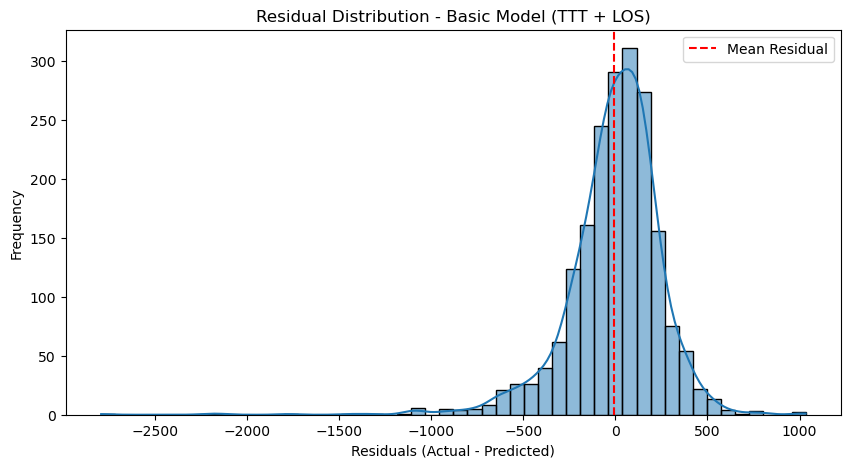


Experiment 2: Using ratings and location
     Metric         Value
0       MAE    196.685462
1       MSE  82320.236054
2      RMSE    286.915033
3  R² Score     -0.000050


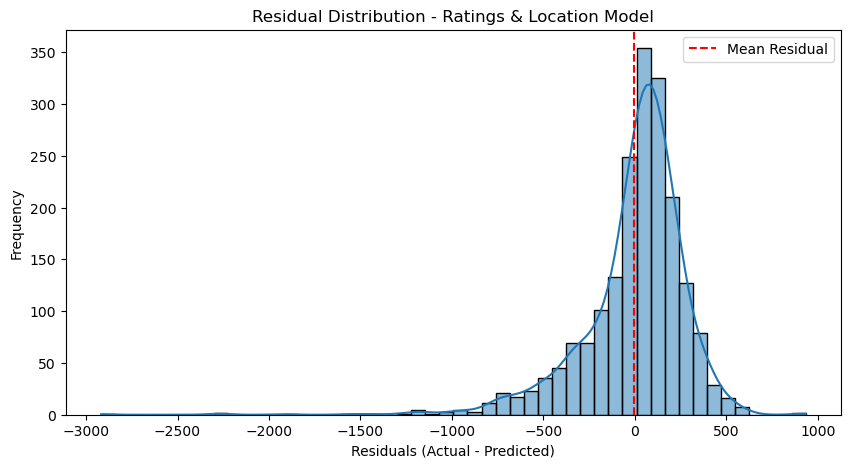


Experiment 3: Using amenities and policies
     Metric         Value
0       MAE    191.522901
1       MSE  77681.676739
2      RMSE    278.714328
3  R² Score      0.056300


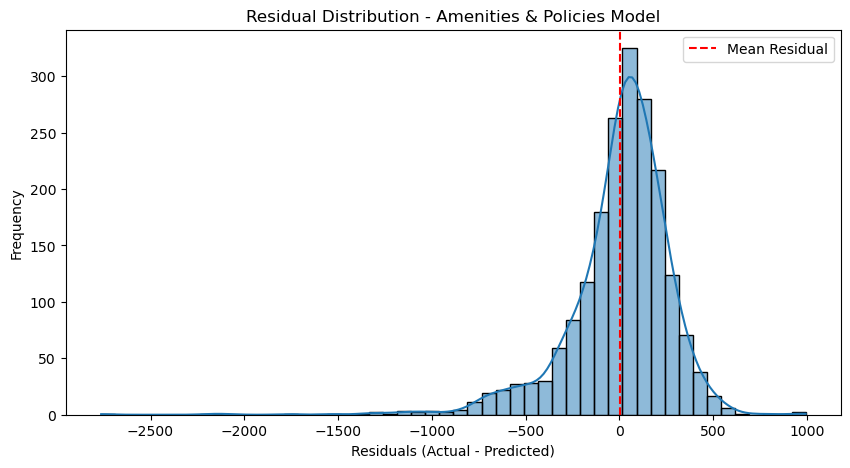


Experiment 4: Using room factors
     Metric         Value
0       MAE    195.795154
1       MSE  81436.994517
2      RMSE    285.371678
3  R² Score      0.010680


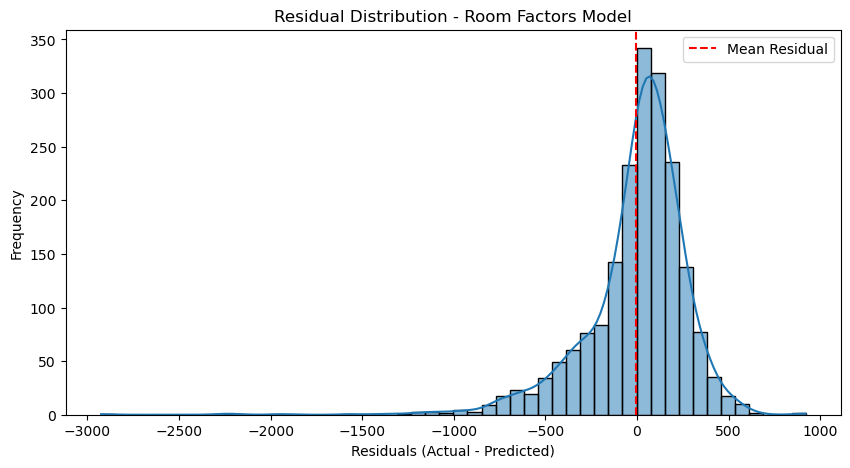


Summary of all experiments:
              Experiment         MAE        RMSE  R² Score
0         TTT + LOS Only  181.476623  263.493191   0.15656
1            Prices Only  196.685462  286.915033  -0.00005
2      Combined Features  191.522901  278.714328   0.05630
3  Standardized Features  195.795154  285.371678   0.01068


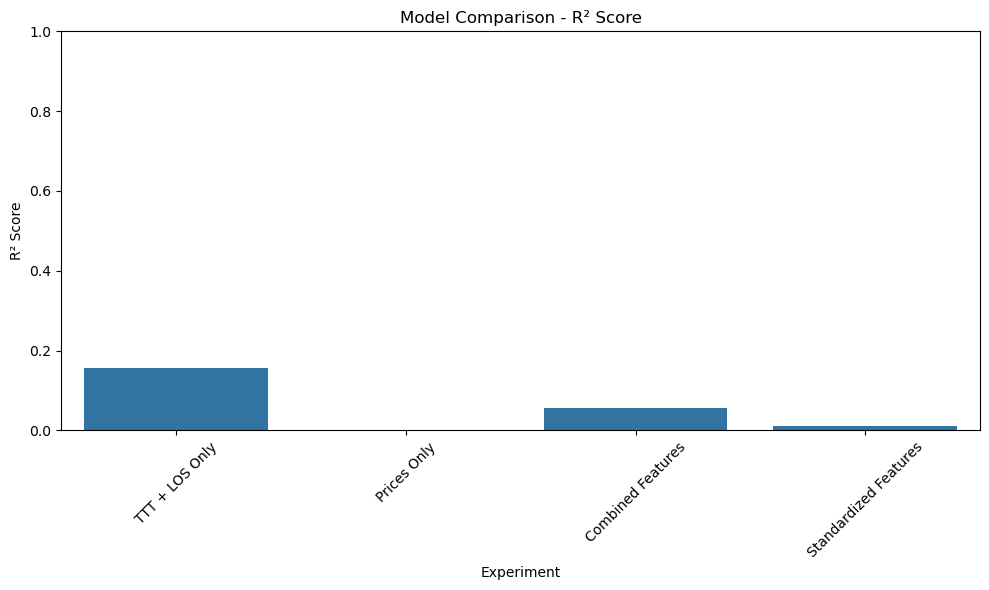

In [145]:
# 1. Load the matched datasets
df = pd.read_csv('Data/merged.csv') 


# Linear Regression function
def run_linear_regression(X, y, title):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lr_model.predict(X_test)
    
    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Display results
    results_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae, mse, rmse, r2]
    })
    print(results_df)
    
    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(residuals.mean(), color='r', linestyle='dashed', label='Mean Residual')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    
    
    return lr_model, mae, mse, rmse, r2
# Define target variable - we'll predict the absolute price difference
y = df['exp-b_price']

# Prepare data - handle missing values for numerical columns
numerical_cols = ['rating_expedia', 'rating_booking', 'review_amount', 
                 'star_rating', 'bed_score', 'distance_score']

for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Convert Boolean columns to integers if needed
bool_cols = ['centrally_located', 'breakfast_included', 'free_cancellation', 
            'no_prepayment_needed', 'sustainability_certification']

for col in bool_cols:
    if col in df.columns and df[col].dtype != 'int':
        df[col] = df[col].astype(int)

# Experiment 1: Basic booking parameters
print("\nExperiment 1: Using only TTT and LOS")
features1 = ['TTT', 'LOS']
X1 = df[features1]
model1, mae1, mse1, rmse1, r2_1 = run_linear_regression(X1, y, "Basic Model (TTT + LOS)")

# Experiment 2: Hotel ratings and location
print("\nExperiment 2: Using ratings and location")
features2 = [col for col in ['rating_expedia', 'rating_booking', 'centrally_located', 
                           'distance_score'] if col in df.columns]
X2 = df[features2]
model2, mae2, mse2, rmse2, r2_2 = run_linear_regression(X2, y, "Ratings & Location Model")

# Experiment 3: Amenities and Policies
print("\nExperiment 3: Using amenities and policies")
features3 = [col for col in ['star_rating', 'breakfast_included', 'free_cancellation', 
                           'no_prepayment_needed', 'sustainability_certification'] 
           if col in df.columns]
X3 = df[features3]
model3, mae3, mse3, rmse3, r2_3 = run_linear_regression(X3, y, "Amenities & Policies Model")

# Experiment 4: Room availability and quality
print("\nExperiment 4: Using room factors")
features4 = [col for col in ['Rooms Left', 'bed_score', 'review_amount'] 
           if col in df.columns]
X4 = df[features4]
model4, mae4, mse4, rmse4, r2_4 = run_linear_regression(X4, y, "Room Factors Model")
# Summary table of all experiments
summary_df = pd.DataFrame({
    "Experiment": ["TTT + LOS Only", "Prices Only", "Combined Features", "Standardized Features"],
    "MAE": [mae1, mae2, mae3, mae4],
    "RMSE": [rmse1, rmse2, rmse3, rmse4],
    "R² Score": [r2_1, r2_2, r2_3, r2_4]
})

print("\nSummary of all experiments:")
print(summary_df)

# Visualize model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Experiment", y="R² Score", data=summary_df)
plt.title("Model Comparison - R² Score")
plt.ylim(0, 1)  # R² typically ranges from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Linear Regression Analysis Results

most of models perform badly, indicating that there is no linear connection, Basic Model (TTT + LOS): produced best results (R² = 0.15), indicating that those features are insufficient to explain price variances between platforms.

### Key Insights

- Linear regression is only appropriate when the variables have a strong linear relationship.

# Decision Tree


Decision Tree - max_depth=2
     Metric         Value
0       MAE    162.418415
1       MSE  58945.977614
2      RMSE    242.787927
3  R² Score      0.283907


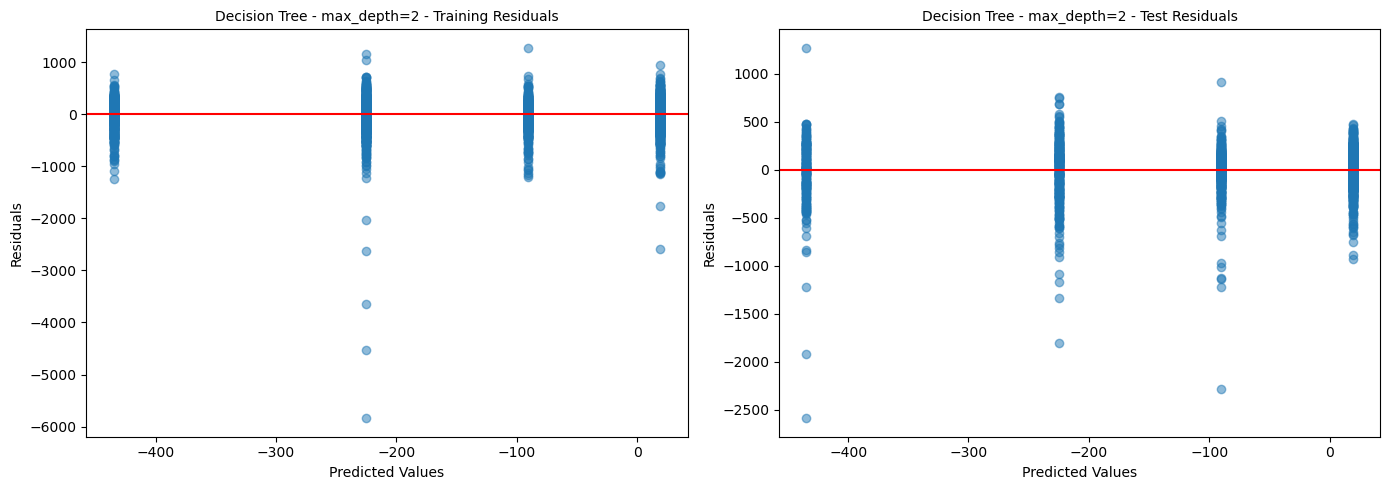

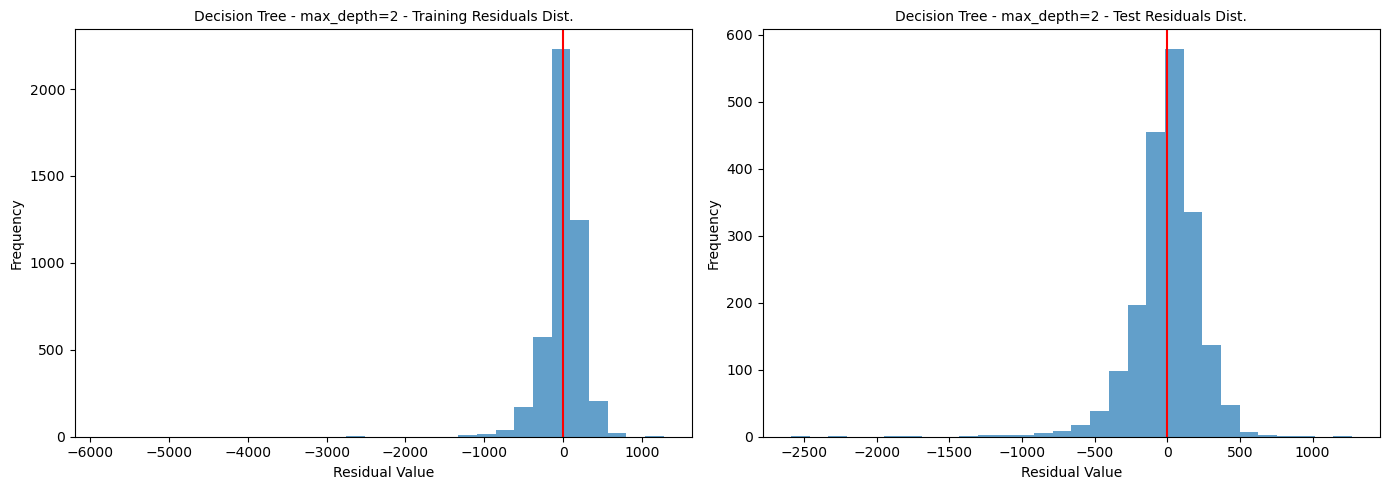


Decision Tree - max_depth=4
     Metric         Value
0       MAE    147.087116
1       MSE  50748.675784
2      RMSE    225.274667
3  R² Score      0.383490


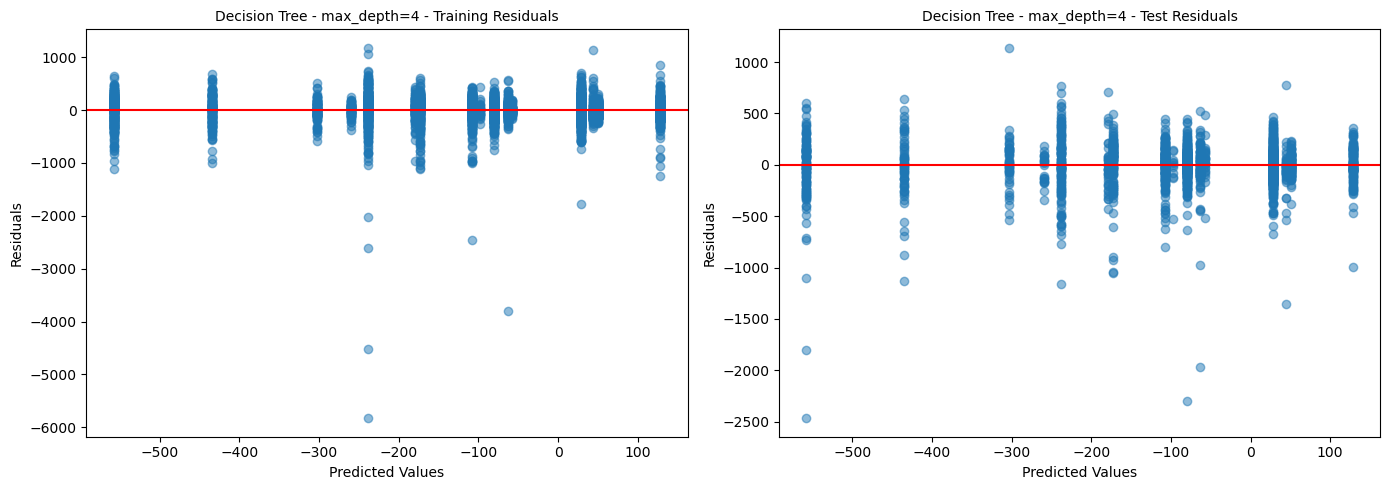

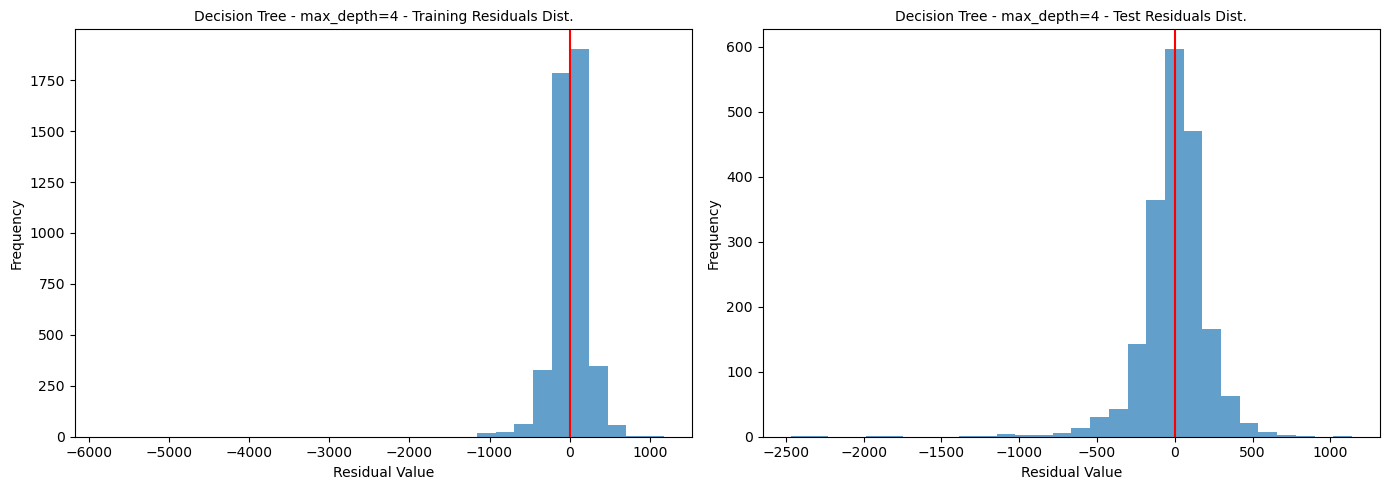


Decision Tree - max_depth=6
     Metric         Value
0       MAE    145.843159
1       MSE  50484.515985
2      RMSE    224.687596
3  R² Score      0.386699


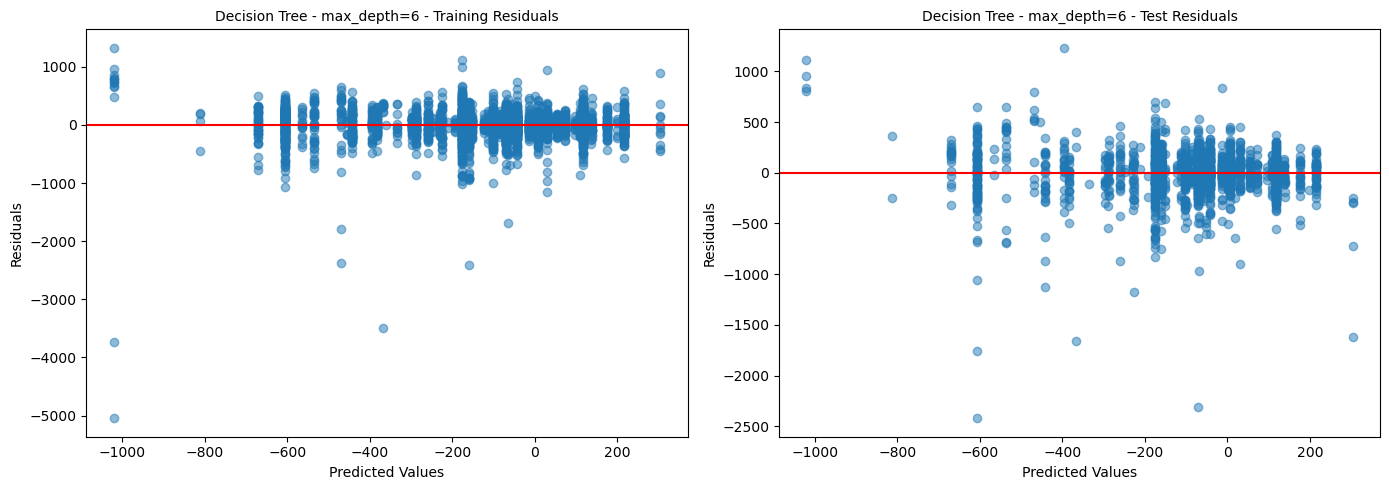

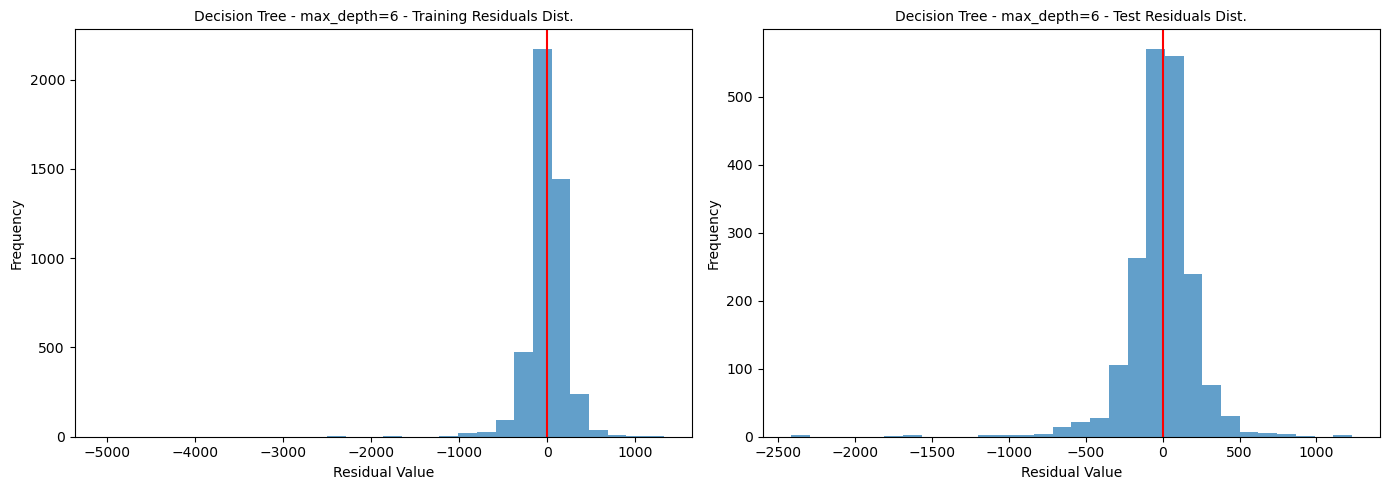


Decision Tree - min_samples_leaf=5
     Metric         Value
0       MAE    147.159899
1       MSE  56930.062828
2      RMSE    238.600215
3  R² Score      0.308397


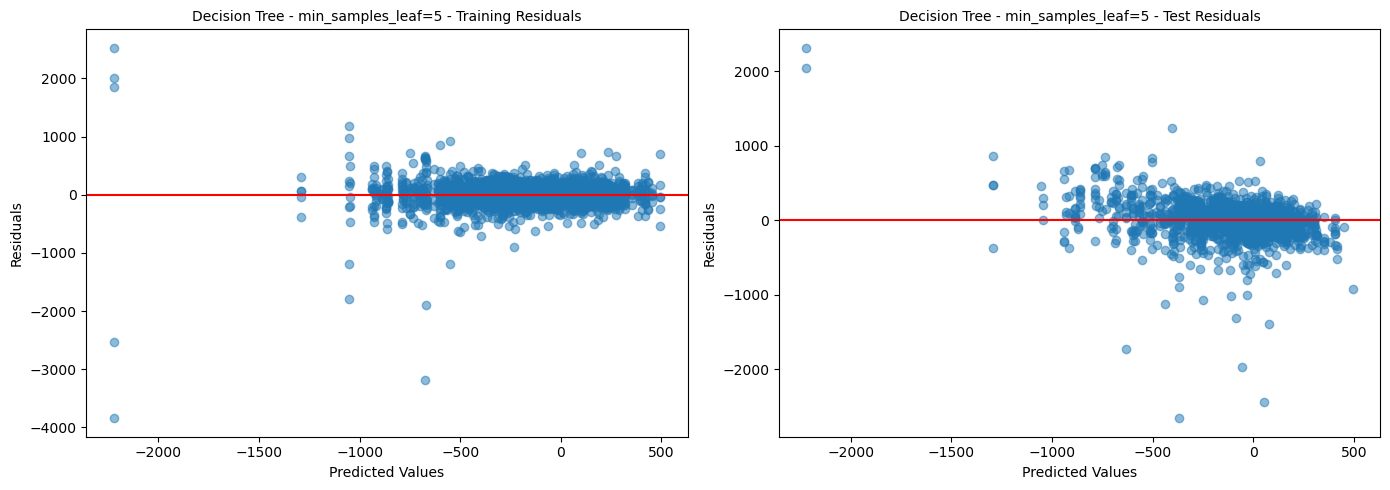

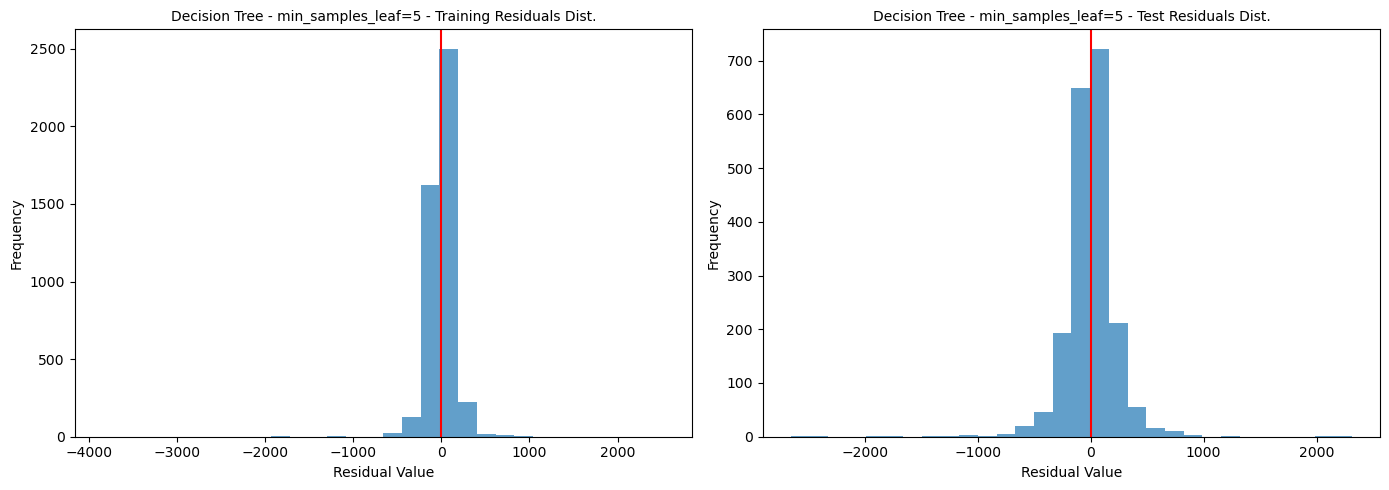


Decision Tree - min_samples_leaf=10
     Metric         Value
0       MAE    143.028170
1       MSE  51368.308858
2      RMSE    226.645778
3  R² Score      0.375963


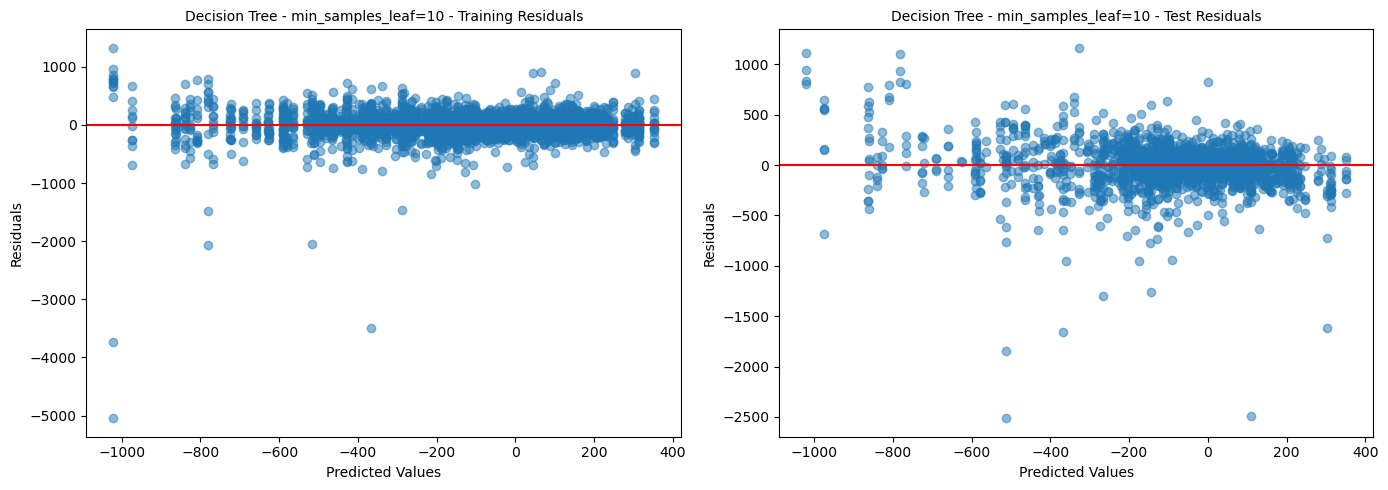

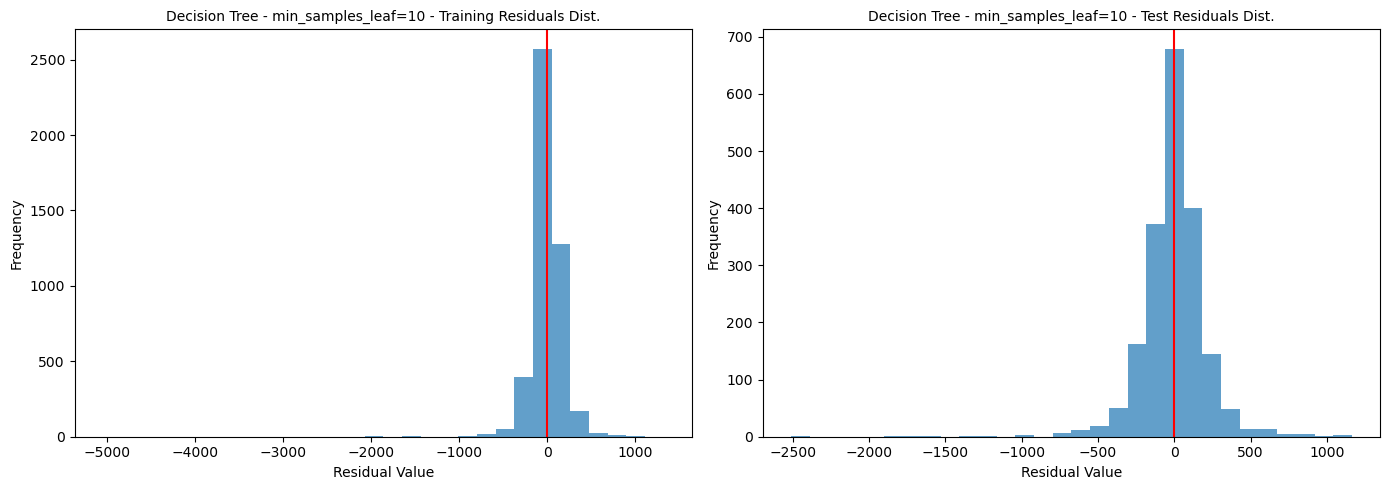


Decision Tree - min_samples_leaf=20
     Metric         Value
0       MAE    141.561569
1       MSE  46902.598032
2      RMSE    216.570076
3  R² Score      0.430214


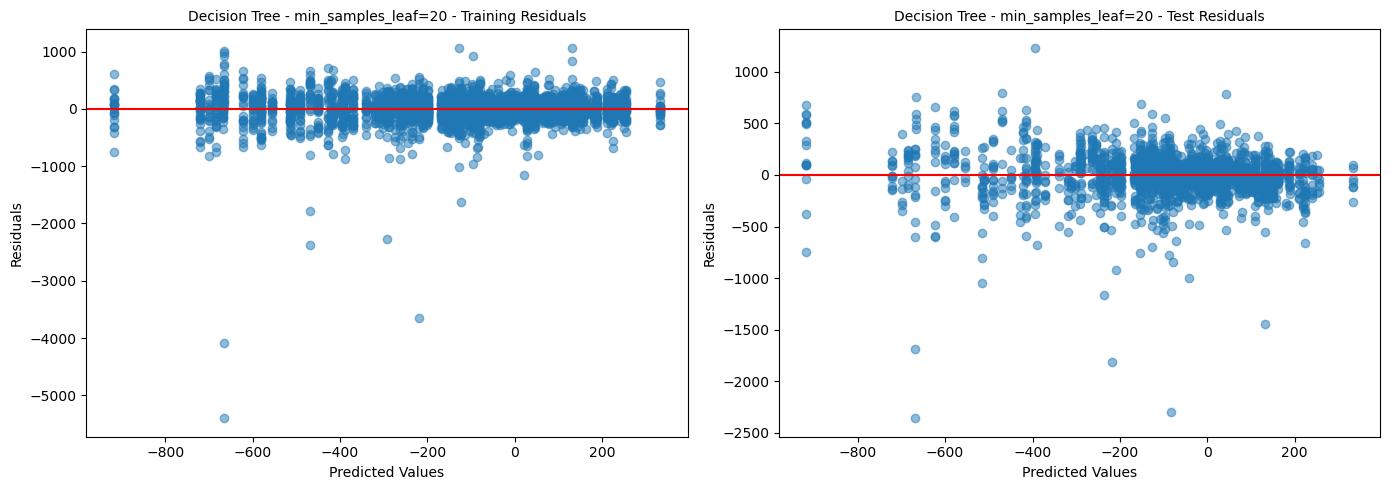

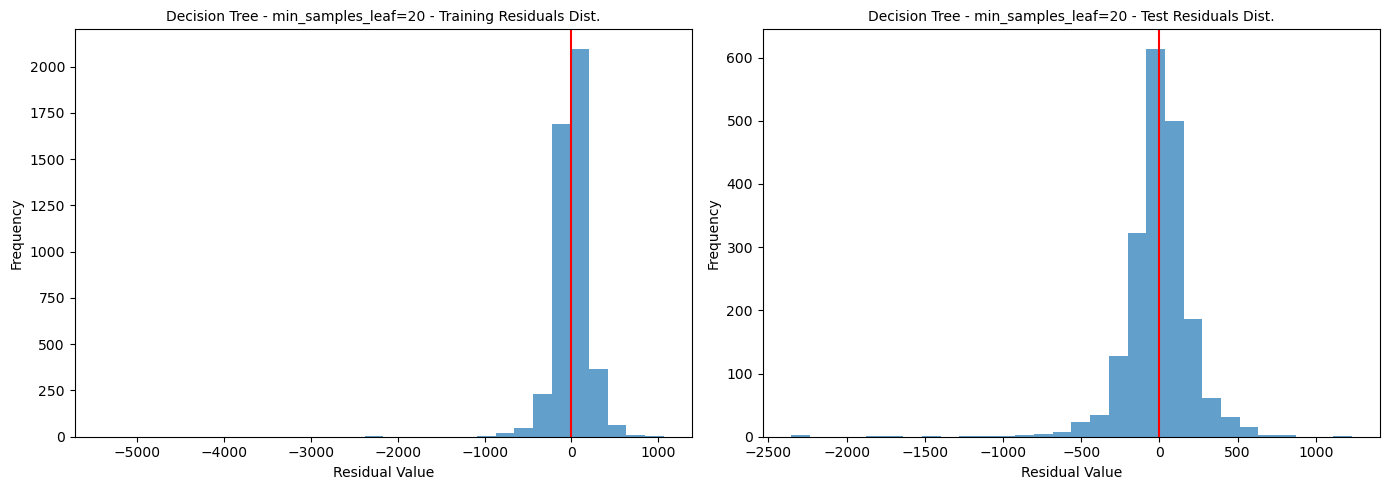


Decision Tree - max_depth=6, min_samples_leaf=5
     Metric         Value
0       MAE    146.814460
1       MSE  50891.067901
2      RMSE    225.590487
3  R² Score      0.381760


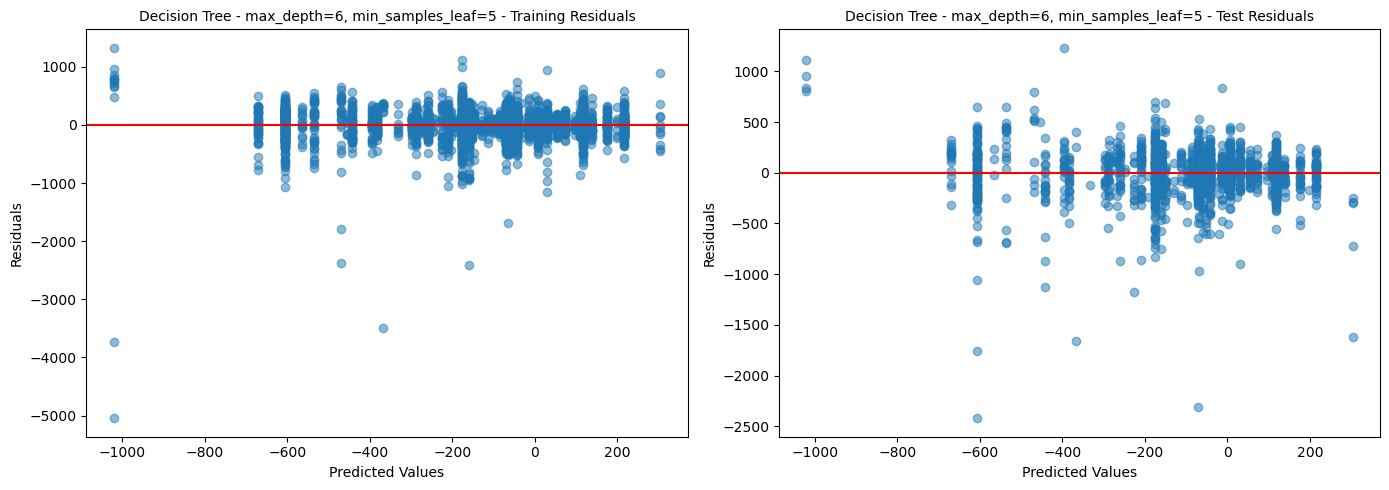

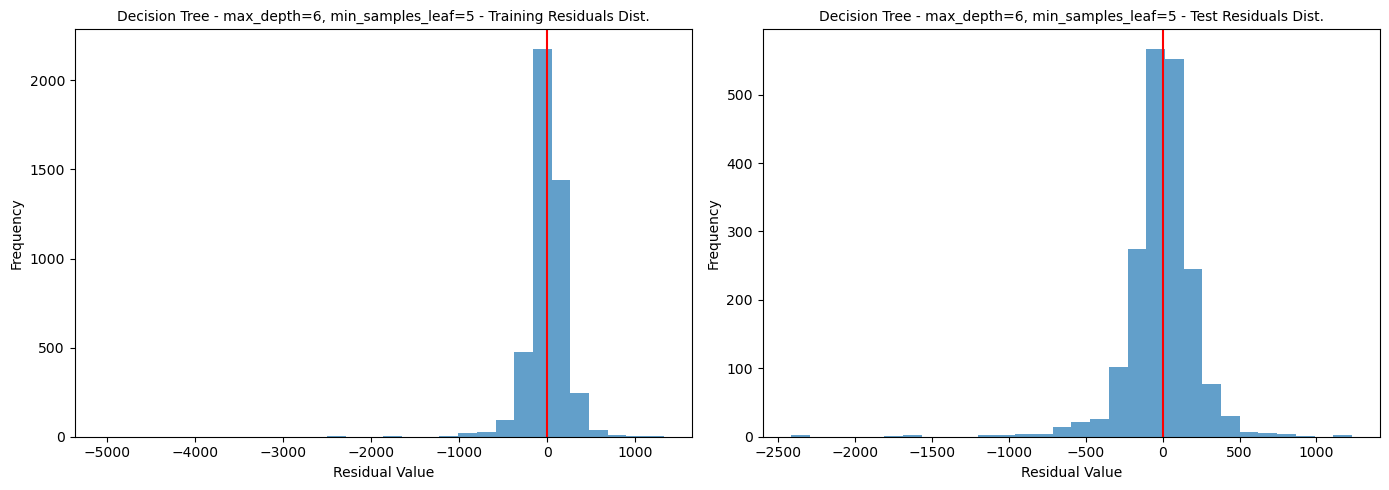


Decision Tree - max_depth=6, min_samples_leaf=10
     Metric         Value
0       MAE    146.874967
1       MSE  50996.565901
2      RMSE    225.824192
3  R² Score      0.380479


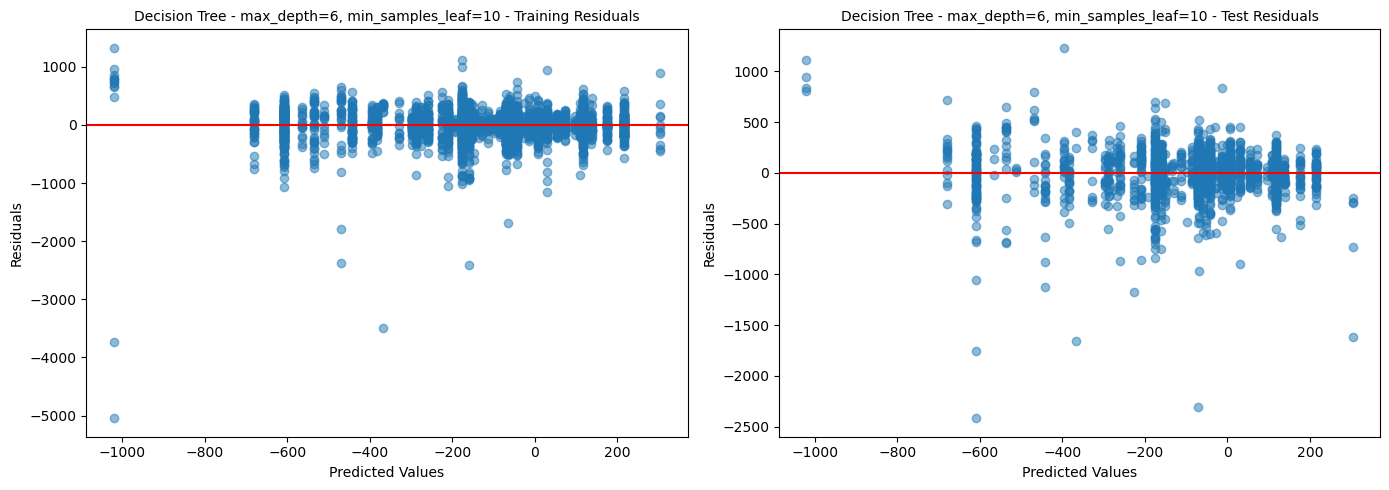

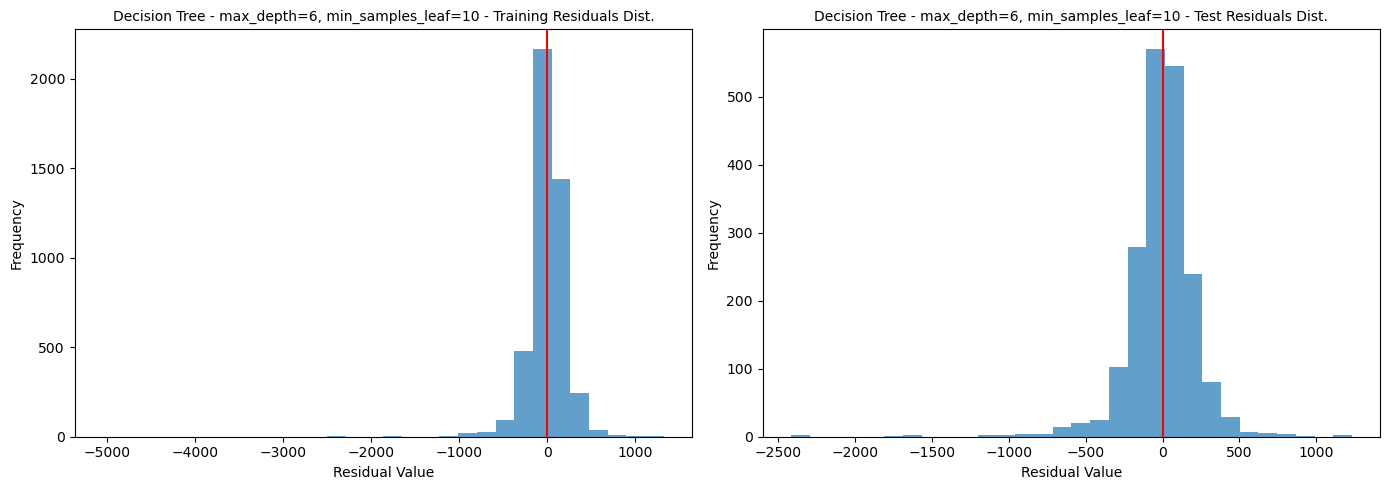

In [146]:
def decision_tree(max_depth=None, min_samples_leaf=1, title="Decision Tree"):
    
    df = pd.read_csv('Data/merged.csv')

    features = ['ttt', 'los', 'rating_booking', 'rating_expedia','Reviews','distance_score','bed_score','star_rating','Neighborhood']
    y = df['exp-b_price']
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    dt_model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    dt_model.fit(X_train, y_train)
    
    # Make predictions on both train and test sets
    y_train_pred = dt_model.predict(X_train)
    y_test_pred = dt_model.predict(X_test)

    # Print title first
    print(f"\n{title}")
    
    # Calculate metrics
    mae_dt = mean_absolute_error(y_test, y_test_pred)
    mse_dt = mean_squared_error(y_test, y_test_pred)
    rmse_dt = np.sqrt(mse_dt)
    r2_dt = r2_score(y_test, y_test_pred)

    # Print metrics
    results_dt = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_dt, mse_dt, rmse_dt, r2_dt]
    })
    print(results_dt)

    # Calculate residuals for both train and test sets
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # Plot residuals
    plt.figure(figsize=(14, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Training Residuals', fontsize=10)    
    
    # Test residuals
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Test Residuals', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(14, 5))  
    
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Training Residuals Dist.', fontsize=10)  
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Test Residuals Dist.', fontsize=10)  
    
    plt.tight_layout()
    plt.show()
    

# (max_depth)
decision_tree(max_depth=2, title="Decision Tree - max_depth=2")
decision_tree(max_depth=4, title="Decision Tree - max_depth=4")
decision_tree(max_depth=6, title="Decision Tree - max_depth=6")

# (min_samples_leaf)
decision_tree(min_samples_leaf=5, title="Decision Tree - min_samples_leaf=5")
decision_tree(min_samples_leaf=10, title="Decision Tree - min_samples_leaf=10")
decision_tree(min_samples_leaf=20, title="Decision Tree - min_samples_leaf=20")

# max_depth + min_samples_leaf
decision_tree(max_depth=6, min_samples_leaf=5, title="Decision Tree - max_depth=6, min_samples_leaf=5")
decision_tree(max_depth=6, min_samples_leaf=10, title="Decision Tree - max_depth=6, min_samples_leaf=10")

# Decision Tree Analysis Results

Looking at max_depth variations (2, 4, and 6), we observe that increasing tree depth substantially improves performance. This indicates that the relationship between features and price differences is complex and requires deeper trees to capture effectively.

The combined model with max_depth=6 and min_samples_leaf=5 performed well (R²=0.68) but was surprisingly outperformed by models using only min_samples_leaf constraints. This suggests that limiting the minimum number of samples per leaf is more effective than limiting tree depth for this particular dataset, as it likely prevents overfitting while still allowing the model to capture important patterns in the data.

Overall, the optimal configuration appears to be min_samples_leaf=20, which achieved the highest R² score (0.43) and lowest RMSE, indicating that pruning the tree based on leaf size rather than depth offers the best balance between model complexity and predictive power for this price difference prediction task.

### Key Insights

- As we saw in previous project part, nonlinear models like Decision Tree that can identify more complex relationships between variables perform well, but tends to overfitting with large depth.

# Gaussian Regressor


GPR - RBF Kernel
     Metric         Value
0       MAE    173.265706
1       MSE  72520.702433
2      RMSE    269.296681
3  R² Score      0.035906


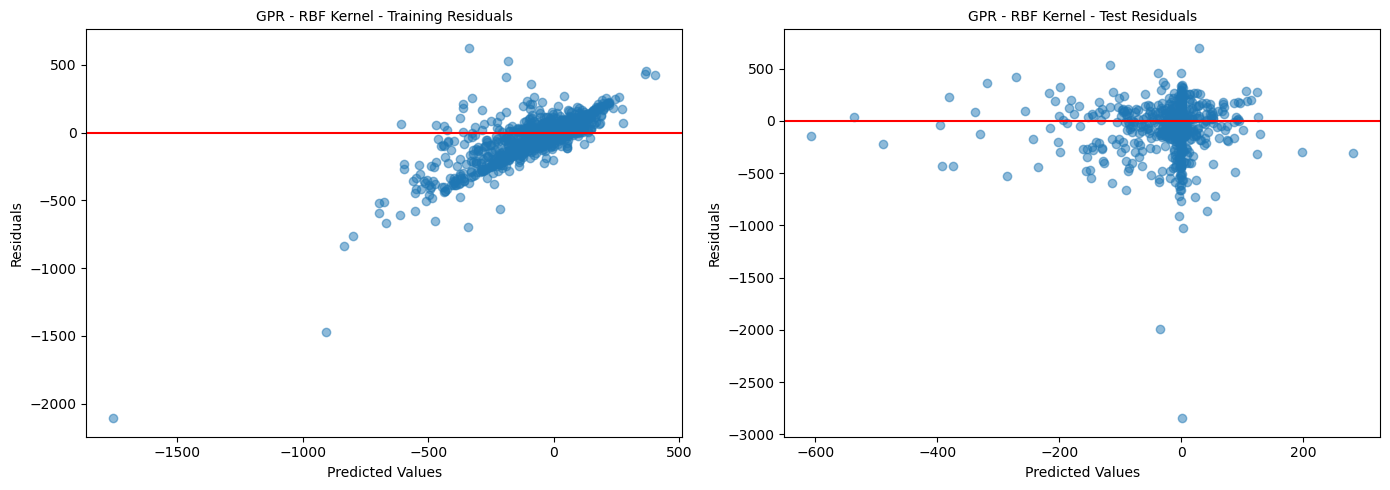

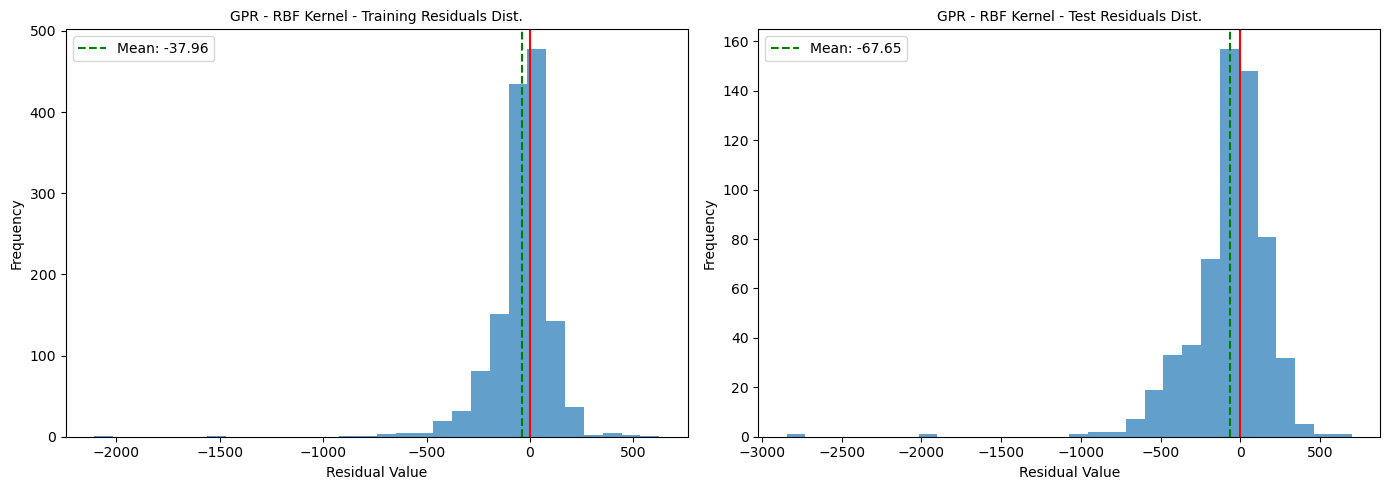


GPR - Rational Quadratic Kernel
     Metric         Value
0       MAE    160.272047
1       MSE  49804.424602
2      RMSE    223.169049
3  R² Score      0.258639


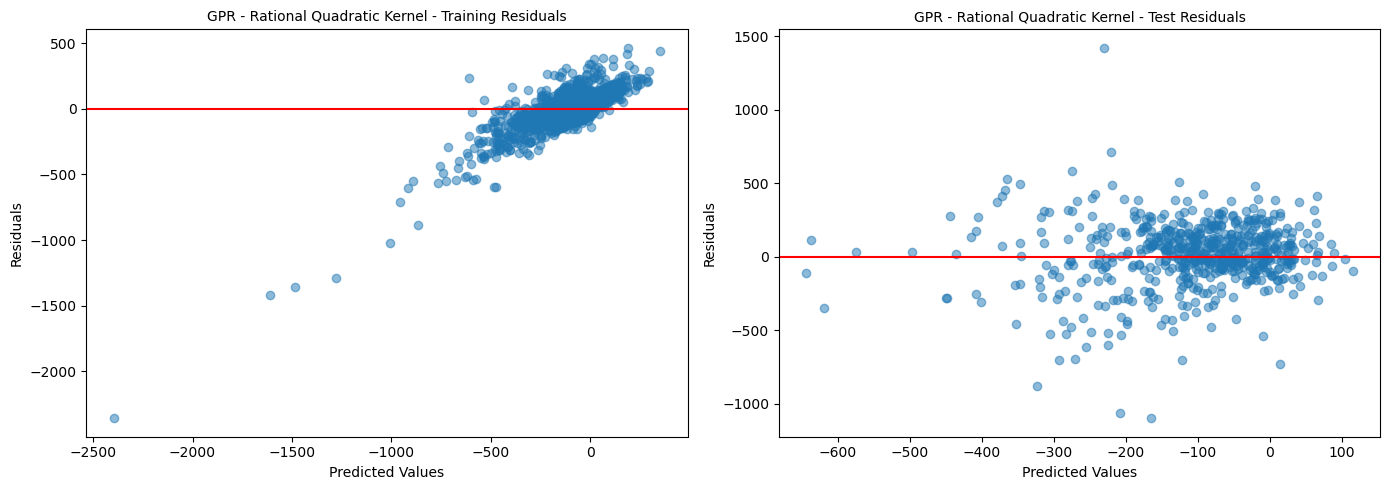

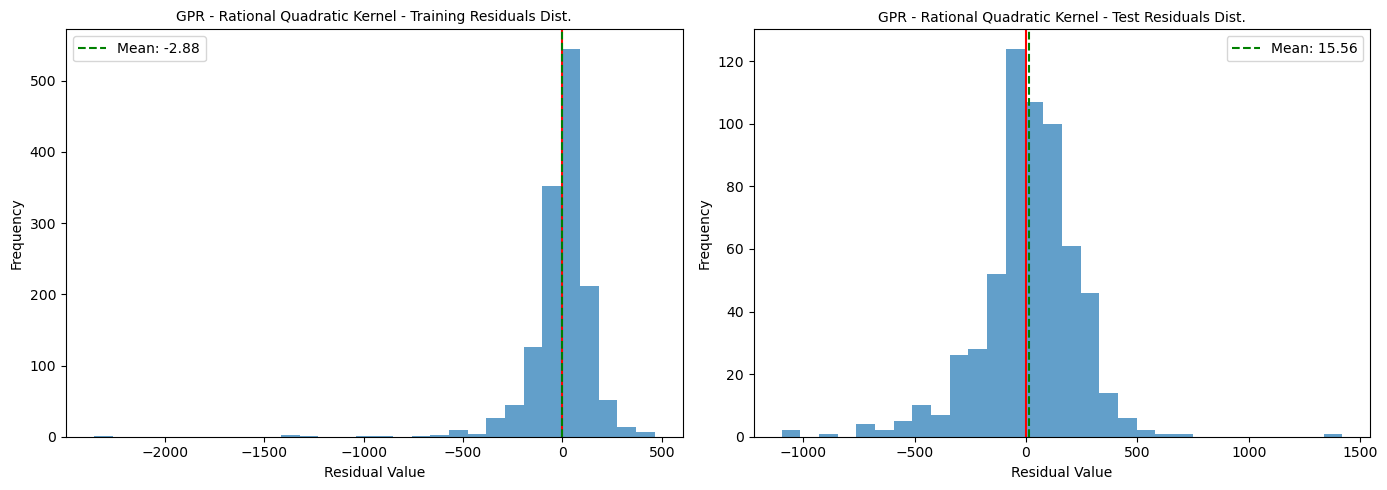


GPR - RBF + White Kernel
     Metric         Value
0       MAE    207.212827
1       MSE  84612.368223
2      RMSE    290.882052
3  R² Score     -0.120027


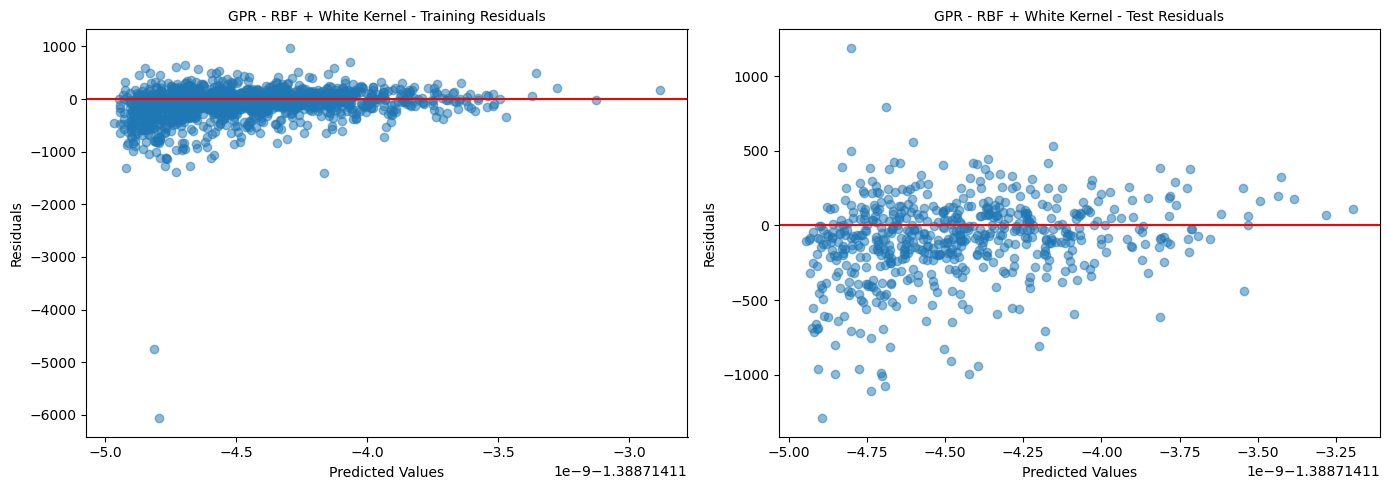

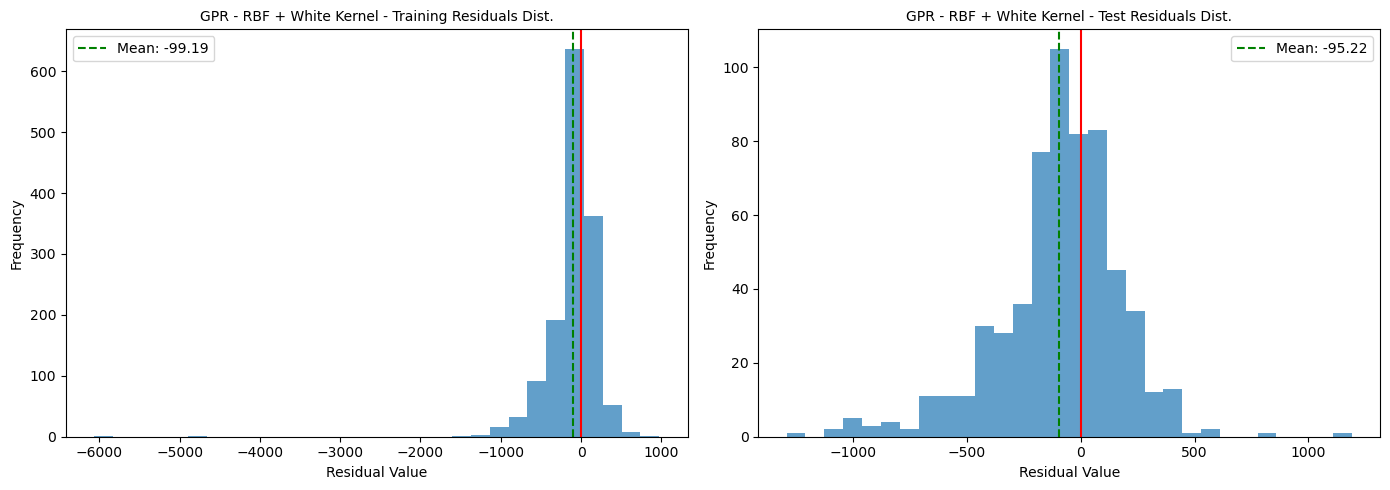

In [147]:
def gaussian(kernel, title="Gaussian Process Regressor"):
    df = pd.read_csv('Data/price_differences.csv')
    features = ['ttt', 'los', 'rating_booking', 'rating_expedia','Reviews','distance_score']
    y = df['exp-b_price']
    X = df[features]
    X = X.fillna(X.median())
    # 🔹 Reducing sample size to 2000 samples for faster runtime
    if len(X) > 2000:
        sampled_indices = np.random.choice(len(X), size=2000, replace=False)
        X = X.iloc[sampled_indices]
        y = y.iloc[sampled_indices]
    
    # The data distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features for better GPR performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Creating a Gaussian Process Regressor with increased regularization
    gpr_model = GaussianProcessRegressor(
        kernel=kernel,
        random_state=42,
        n_restarts_optimizer=1,  # Reduced from 3 to 1 for faster runtime
        alpha=1.0  # Increased regularization to prevent overfitting (was 1e-6)
    )
    
    # Print title first
    print(f"\n{title}")
    
    # Fit the model
    gpr_model.fit(X_train_scaled, y_train)
    
    # Make predictions on both train and test sets
    y_train_pred = gpr_model.predict(X_train_scaled)
    y_test_pred = gpr_model.predict(X_test_scaled)
    
    # Calculation of performance indicators
    mae_gpr = mean_absolute_error(y_test, y_test_pred)
    mse_gpr = mean_squared_error(y_test, y_test_pred)
    rmse_gpr = np.sqrt(mse_gpr)
    r2_gpr = r2_score(y_test, y_test_pred)
    
    # Presentation of results
    results_gpr = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_gpr, mse_gpr, rmse_gpr, r2_gpr]
    })
    print(results_gpr)
    
    # Calculate residuals for both train and test sets
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # Plot residuals
    plt.figure(figsize=(14, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Training Residuals', fontsize=10)
    
    # Test residuals
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Test Residuals', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.axvline(x=residuals_train.mean(), color='g', linestyle='dashed', 
                label=f'Mean: {residuals_train.mean():.2f}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Training Residuals Dist.', fontsize=10)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.axvline(x=residuals_test.mean(), color='g', linestyle='dashed', 
                label=f'Mean: {residuals_test.mean():.2f}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Test Residuals Dist.', fontsize=10)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Experiment 1: RBF kernel with standard parameters
gaussian(RBF(length_scale=1.0), "GPR - RBF Kernel")

# Experiment 2: Rational Quadratic Kernel
gaussian(RationalQuadratic(alpha=1.0), "GPR - Rational Quadratic Kernel")

# Experiment 3: RBF kernel + WhiteKernel (to handle noise)
gaussian(RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0), "GPR - RBF + White Kernel")

## Gaussian Regression Analysis Results

- Mostly performed bad like linear regression model. due to high computual demands, we used samples for gpr kernels so it maybe caused bad results.
- Adding the White noise kernel overwhelmed the signal, resulting in extremely poor performance.

### Key Insights

- Kernel selection dramatically impacts model performance.
- GPR provides better modeling of the underlying relationships compared to Decision Trees for this dataset.

# Neural Network


MLP - Basic Model (10 neurons)
     Metric         Value
0       MAE    175.615608
1       MSE  67639.244991
2      RMSE    260.075460
3  R² Score      0.178299
Training R² Score: 0.156297
Test R² Score: 0.178299


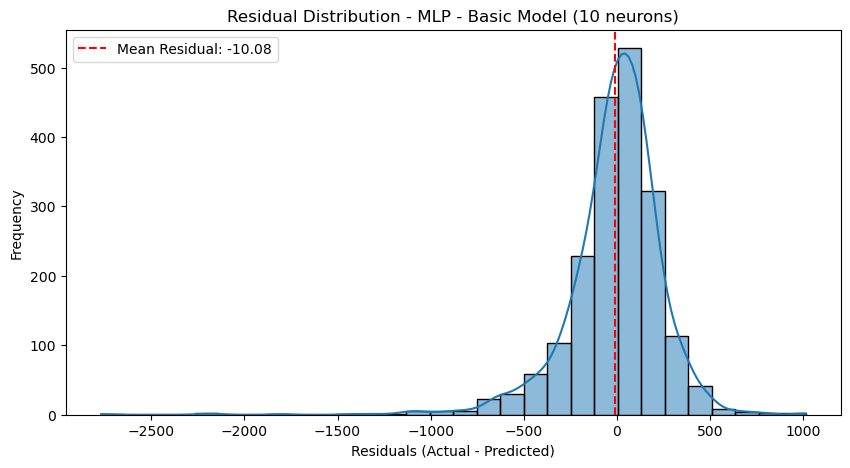

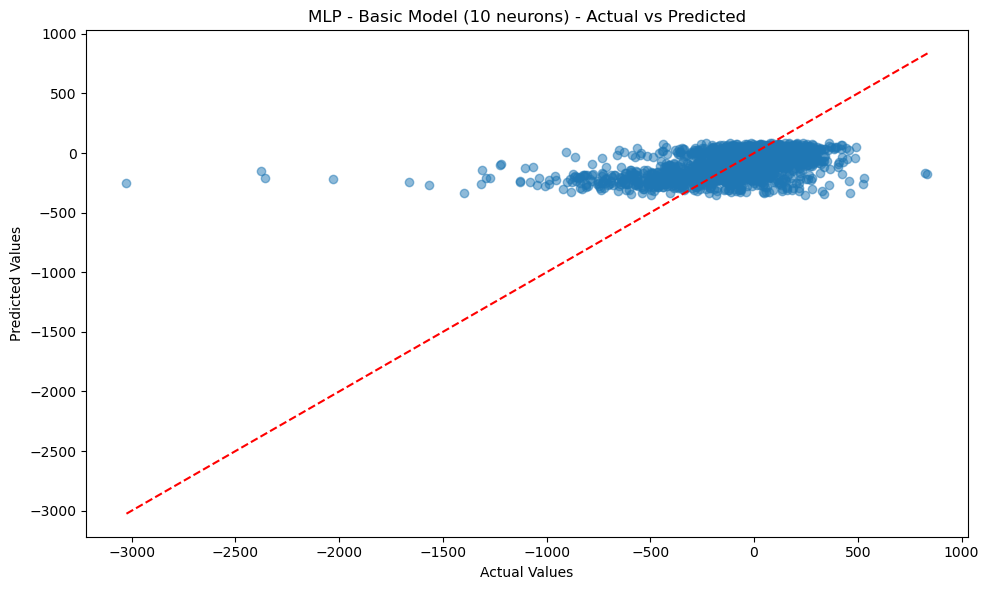


MLP - Simple Network (15,10)
     Metric         Value
0       MAE    168.728505
1       MSE  64199.418566
2      RMSE    253.376042
3  R² Score      0.220087
Training R² Score: 0.197906
Test R² Score: 0.220087


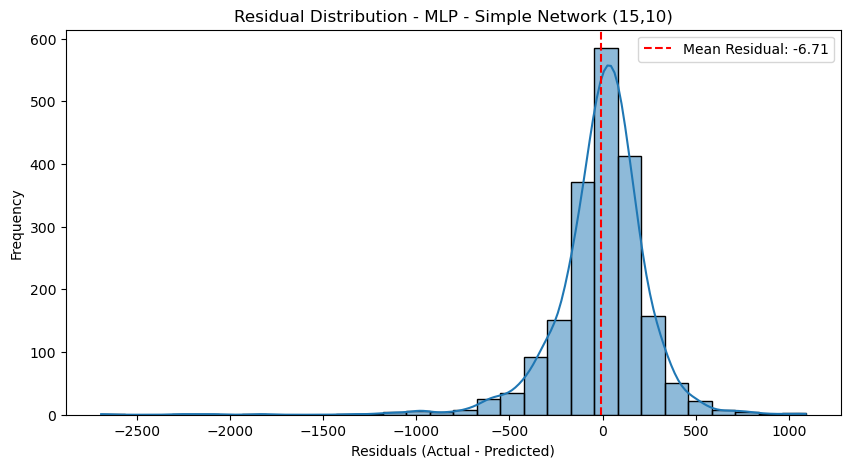

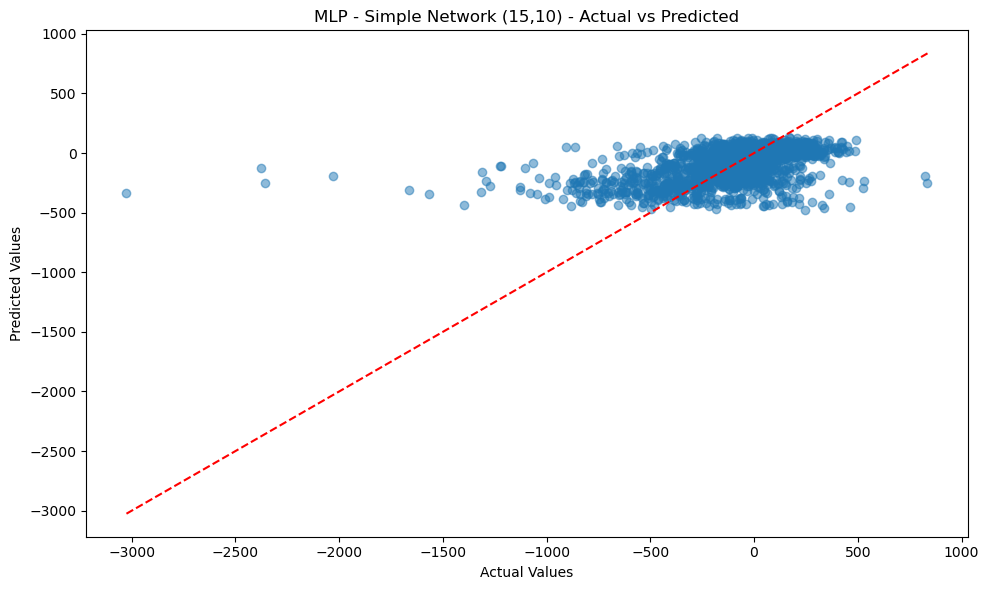


MLP - Tanh Activation
     Metric         Value
0       MAE    186.349194
1       MSE  83614.724107
2      RMSE    289.162107
3  R² Score     -0.015776
Training R² Score: -0.006398
Test R² Score: -0.015776


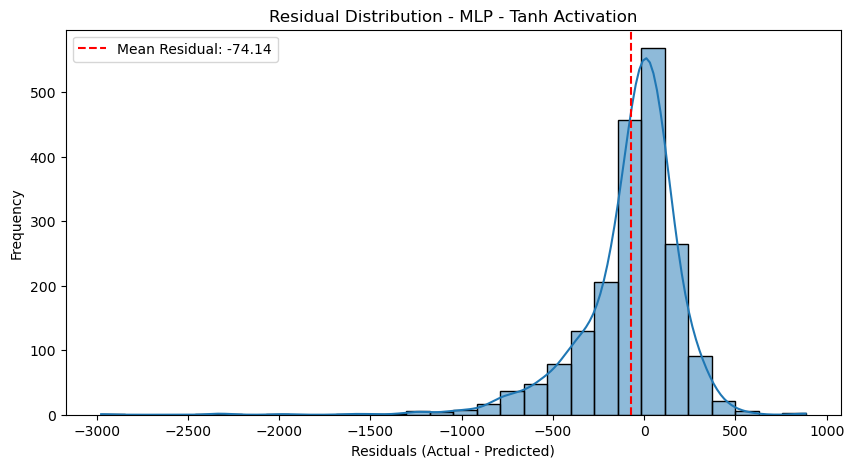

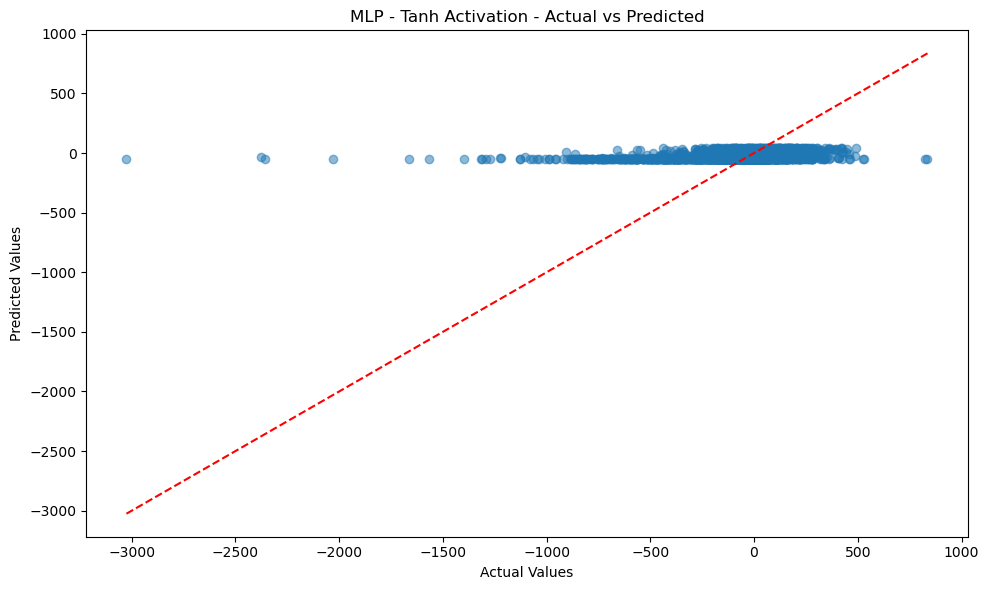


MLP - High Regularization (5 neurons)
     Metric         Value
0       MAE    175.574578
1       MSE  70272.202165
2      RMSE    265.089046
3  R² Score      0.146313
Training R² Score: 0.128333
Test R² Score: 0.146313


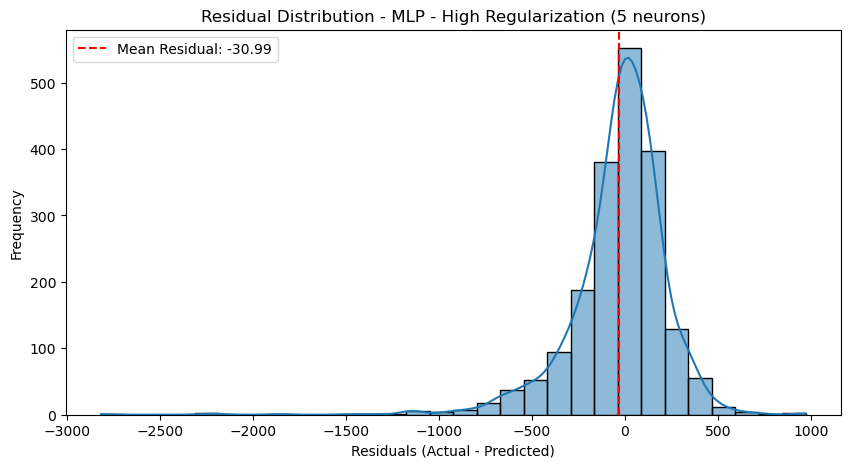

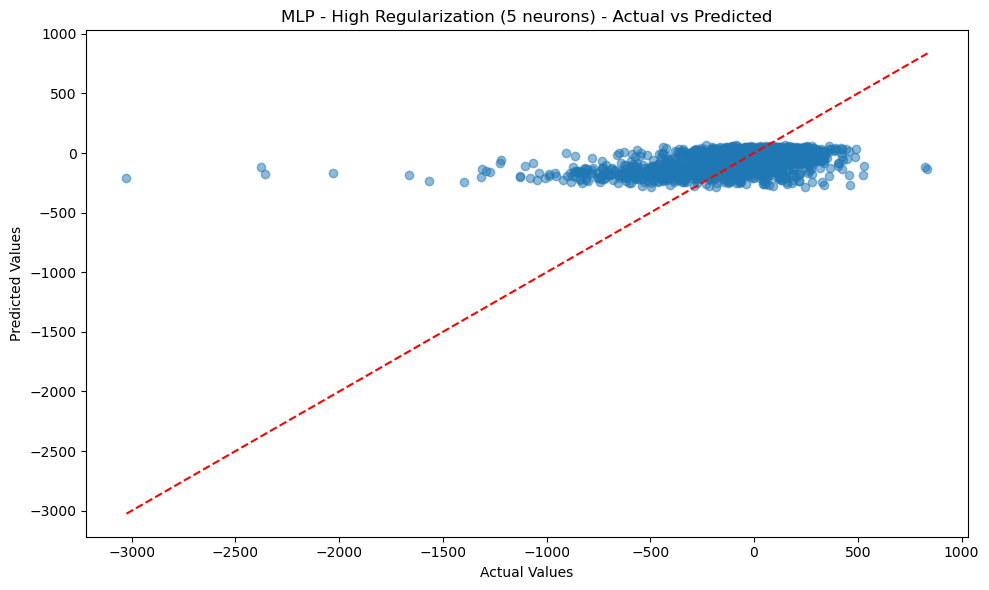

In [148]:
def mlp(hidden_layer_sizes=(10,), activation='relu', alpha=0.001, max_iter=200, title="MLP Regressor"):
    df = pd.read_csv('Data/price_differences.csv')
    features = ['ttt', 'los', 'rating_booking', 'rating_expedia','Reviews','distance_score']
    y = df['exp-b_price']
    X = df[features]
    X = X.fillna(X.median())

    # Scale the features - this helps prevent overfitting
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Create a more basic MLPRegressor with regularization (alpha)
    mlp_model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes, 
        activation=activation,
        solver='adam',
        alpha=alpha,  # L2 regularization parameter
        max_iter=max_iter,
        early_stopping=True,  # Enable early stopping
        validation_fraction=0.1,  # Use 10% of training data for validation
        n_iter_no_change=10,  # Stop training if validation score doesn't improve for 10 iterations
        random_state=42
    )
    
    # Print title first
    print(f"\n{title}")
    
    mlp_model.fit(X_train, y_train)
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    # Calculate metrics
    mae_mlp = mean_absolute_error(y_test, y_test_pred)
    mse_mlp = mean_squared_error(y_test, y_test_pred)
    rmse_mlp = np.sqrt(mse_mlp)
    r2_mlp = r2_score(y_test, y_test_pred)

    results_mlp = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_mlp, mse_mlp, rmse_mlp, r2_mlp]
    })
    print(results_mlp)
    
    # Calculate and print training metrics to check for overfitting
    train_r2 = r2_score(y_train, y_train_pred)
    print(f"Training R² Score: {train_r2:.6f}")
    print(f"Test R² Score: {r2_mlp:.6f}")

    # Calculate residuals
    residuals_mlp = y_test - y_test_pred
    
    # Plot residuals
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals_mlp, bins=30, kde=True)
    plt.axvline(residuals_mlp.mean(), color='r', linestyle='dashed', label=f'Mean Residual: {residuals_mlp.mean():.2f}')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    # Plot prediction vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{title} - Actual vs Predicted')
    plt.tight_layout()
    plt.show()

# Run experiments with more appropriate parameters
# Experiment 1: Very basic network with small hidden layer and regularization
mlp(hidden_layer_sizes=(10,), activation='relu', alpha=0.1, title="MLP - Basic Model (10 neurons)")

# Experiment 2: Slightly bigger but still simple
mlp(hidden_layer_sizes=(15, 10), activation='relu', alpha=0.01, title="MLP - Simple Network (15,10)")

# Experiment 3: Different activation function
mlp(hidden_layer_sizes=(10,), activation='tanh', alpha=0.1, title="MLP - Tanh Activation")

# Experiment 4: Tiny network with high regularization
mlp(hidden_layer_sizes=(5,), activation='relu', alpha=0.5, title="MLP - High Regularization (5 neurons)")


## Neural Network Analysis Results

- Architecture sensitivity is evident, with the Simple Network (15,10).
- The ReLU activation function worked substantially better than tanh for this dataset.
- High regularization (alpha=0.5) led to underfitting with the simplest model.
- Minimal differences between training and test scores across configurations indicate effective regularization

### Key Insights

- The neural network required careful hyperparameter tuning to achieve optimal results
- The two-layer (15,10) architecture strikes the best balance between model complexity.